# XGBoost feature selection
(using stratified 5-fold cross validation)

## Plain English summary
Machine learning algorithms (such as XGBoost) were devised to deal with enormous and complex datasets, with the approach that the more data that you can throw at them, the better, and let the algorithms work it out themselves. 

However this approach can make it tricky to be able to explain a coherent story about how the models are working, the relationships that they have found, and how they have made their predictions. 

Our machine learning work has taken on an additional focus - to make our work as explainable as possible. Both in terms of being able to explain how the models have arrived at their outcome, and in the ease at which we can disseminate our work to a wider audience. For us to have explainable models we want to have a balance between model complexity and model accuracy in order to be able to explain our models, whilst maintaining model performance. 

In this notebook we create a model to predict if a patient should receive thrombolysis using just a single input feature, chosen as the feature that gave the model it's best performance. The single feature that gave the best model performance was "Arrival-to-scan time". Fixing this feature in the model, we repeated the process to chose the next single feature to add to the model. The best single feature to include next was "Stroke type". We repeated this process, choosing the next feature to add to the model until 25 features were included (it was limited to 25 features for computational time purposes). We found that a model with eight features is able to provide 99% of the accuracy obtained when all 84 features are used, and that these eight features are also independent of each other (refer to section *Check correlation between selected features* to confirm this). 

This is not saying that these are the 8 most important features, as another highly correlated feature may also have been important, but it is now not needed to be included in the model.

We will train future models using these eight features.

## Model and data

XGBoost models were trained on stratified k-fold cross-validation data. The full dataset contains 84 features that describe the patient (in terms of their clinical characteristics, the stroke pathway, and the stroke team that they attended). Features to be included in the model were sequentially selected as the single best feature to add to the model in terms of performance from the area under the receiver operating characteristic (ROC AUC) curve. When included, the hospital feature is included as a one-hot encoded feature.

## Aims

* Select up to 25 features (from the full set of 84 features) using forward feature selection. Features are selected sequentially (using the greedy approach), choosing the feature that leads to most improvement in ROC AUC score.
* Decide on the number of features to include in future models

## Observations
Eight features are able to provide a ROC AUC of 0.917 out of a maximum of 0.922. These features are also independent of each other.

Our best model with 1, 2, 8 & 84 features had a ROC AUC of 0.715, 0.792, 0.917 & 0.922.

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

import json

## Create output folder if needed

In [2]:
path = './output'
if not os.path.exists(path):
    os.makedirs(path)

## Load data

Data has previously been split into 5 stratified k-fold splits.

In [3]:
data_loc = '../data/kfold_5fold/'

In [4]:
train_data, test_data = [], []

for i in range(5):
    
    train_data.append(pd.read_csv(data_loc + 'train_{0}.csv'.format(i)))
    test_data.append(pd.read_csv(data_loc + 'test_{0}.csv'.format(i)))

## Get list of features

In [5]:
features = list(train_data[0])

## Fit XGBoost model

Loop through each feature in turn and train an XGBoost model with that feature added to the dataset (for each k-fold split). Choose the single best feature to add to the model in terms of performance from the ROC AUC (mean of the k-fold splits).

Repeat until 25 features have been selected.

In [6]:
# Create list to store accuracies and chosen features
roc_auc_by_feature_number = []
roc_auc_by_feature_number_kfold = []
chosen_features = []

# Initialise chosen features list and run tracker
available_features = list(train_data[0].drop('S2Thrombolysis', axis=1))
number_of_features = len(available_features)

# Loop through number of features
for i in range (25):
    
    # Reset best feature and accuracy
    best_result = 0
    best_feature = ''
    
    # Loop through available features
    for feature in available_features:

        # Create copy of already chosen features to avoid original being changed
        features_to_use = chosen_features.copy()
        # Create a list of features from features already chosen + 1 new feature
        features_to_use.append(feature)
        
        # Set up a list to hold AUC results for this feature for each kfold
        feature_auc_kfold = []
        
        # Loop through k folds
        for k_fold in range(5):

            # Get k fold split
            train = train_data[k_fold]
            test = test_data[k_fold]

            # Get X and y
            X_train = train.drop('S2Thrombolysis', axis=1)
            X_test = test.drop('S2Thrombolysis', axis=1)
            y_train = train['S2Thrombolysis']
            y_test = test['S2Thrombolysis']
            
            # Restrict features
            X_train = X_train[features_to_use]
            X_test = X_test[features_to_use]
    
            # One hot encode hospitals if hospital in features used
            if 'StrokeTeam' in features_to_use:
                X_train_hosp = pd.get_dummies(
                    X_train['StrokeTeam'], prefix = 'team')
                X_train = pd.concat([X_train, X_train_hosp], axis=1)
                X_train.drop('StrokeTeam', axis=1, inplace=True)
                X_test_hosp = pd.get_dummies(
                    X_test['StrokeTeam'], prefix = 'team')
                X_test = pd.concat([X_test, X_test_hosp], axis=1)
                X_test.drop('StrokeTeam', axis=1, inplace=True)    

            # Define model
            model = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)

            # Fit model
            model.fit(X_train, y_train)

            # Get predicted probabilities
            y_probs = model.predict_proba(X_test)[:,1]
            
            # Get ROC AUC
            fpr, tpr, thresholds = roc_curve(y_test, y_probs)
            roc_auc = auc(fpr, tpr)
            feature_auc_kfold.append(roc_auc)
        
        # Get average result from all k-fold splits
        feature_auc_mean = np.mean(feature_auc_kfold)
    
        # Update chosen feature and result if this feature is a new best
        if feature_auc_mean > best_result:
            best_result = feature_auc_mean
            best_result_kfold = feature_auc_kfold
            best_feature = feature
            
    # k-fold splits are complete    
    # Add mean accuracy and AUC to record of accuracy by feature number
    roc_auc_by_feature_number.append(best_result)
    roc_auc_by_feature_number_kfold.append(best_result_kfold)
    chosen_features.append(best_feature)
    available_features.remove(best_feature)
            
    print (f'Feature {i+1:2.0f}: {best_feature}, AUC: {best_result:0.3f}')

Feature  1: S2BrainImagingTime_min, AUC: 0.715
Feature  2: S2StrokeType_Infarction, AUC: 0.792
Feature  3: S2NihssArrival, AUC: 0.850
Feature  4: S1OnsetTimeType_Precise, AUC: 0.875
Feature  5: S2RankinBeforeStroke, AUC: 0.890
Feature  6: StrokeTeam, AUC: 0.903
Feature  7: AFAnticoagulent_Yes, AUC: 0.914
Feature  8: S1OnsetToArrival_min, AUC: 0.916
Feature  9: S1OnsetDateType_Stroke during sleep, AUC: 0.917
Feature 10: BestLanguage, AUC: 0.918
Feature 11: MoreEqual80y_Yes, AUC: 0.919
Feature 12: LocQuestions, AUC: 0.920
Feature 13: StrokeTIA_Yes, AUC: 0.920
Feature 14: LimbAtaxia, AUC: 0.921
Feature 15: Loc, AUC: 0.921
Feature 16: S2NewAFDiagnosis_No, AUC: 0.921
Feature 17: S1AdmissionHour_18:00 to 20:59, AUC: 0.922
Feature 18: S1OnsetInHospital_Yes, AUC: 0.922
Feature 19: S1Ethnicity_Mixed, AUC: 0.922
Feature 20: S1OnsetDateType_Precise, AUC: 0.922
Feature 21: AFAnticoagulentVitK_No, AUC: 0.922
Feature 22: AFAntiplatelet_No but, AUC: 0.922
Feature 23: S1Ethnicity_Black, AUC: 0.922
Fea

Create a dataframe that contains the chosen features, and their mean ROC AUC across the k-fold splits, and the standard deviation.

In [7]:
results = pd.DataFrame()
results['number_features'] = range(1, len(chosen_features)+1)
results['feature'] = chosen_features
results['AUC'] = roc_auc_by_feature_number
results['AUC_Std'] = [np.std(auc) for auc in roc_auc_by_feature_number_kfold]
results

,number_features,feature,AUC,AUC_Std
0,1,S2BrainImagingTime_min,0.715332,0.003247
1,2,S2StrokeType_Infarction,0.791939,0.003900
2,3,S2NihssArrival,0.849530,0.002800
3,4,S1OnsetTimeType_Precise,0.874870,0.002517
4,5,S2RankinBeforeStroke,0.890313,0.002097
5,6,StrokeTeam,0.903222,0.002272
6,7,AFAnticoagulent_Yes,0.913876,0.001896
7,8,S1OnsetToArrival_min,0.915791,0.002128
8,9,S1OnsetDateType_Stroke during sleep,0.917436,0.002507
9,10,BestLanguage,0.918334,0.002303


## Plot the results

Plot a line graph showing the change in mean ROC AUC (across k-fold splits) for the number of features chosen in the model. 

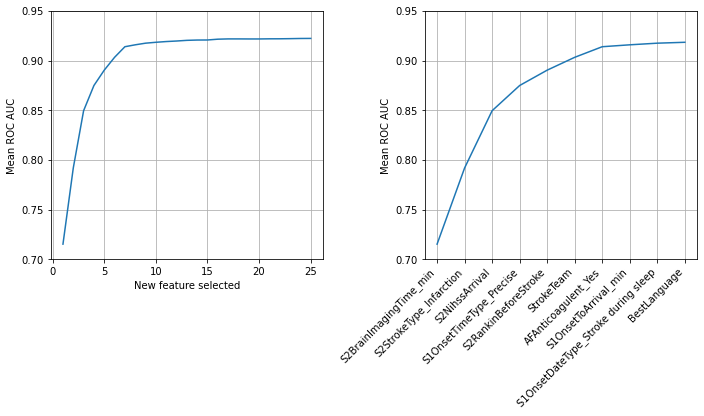

In [8]:
features_to_show = 10

fig = plt.figure(figsize=(10,6))

ax1 = fig.add_subplot(121)
ax1.plot(results['number_features'], results['AUC'])
ax1.set_xlabel('Number of features')
ax1.set_ylabel('Mean ROC AUC')
ax1.set_ylim(0.7, 0.95)
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.plot(results['feature'][:features_to_show],
         results['AUC'][:features_to_show])
xlabels = list(results['feature'])
xlabels = xlabels[:features_to_show]
ax2.set_xticklabels(xlabels, rotation=45, ha='right')
ax2.set_ylabel('Mean ROC AUC')
ax1.set_xlabel('New feature selected')
ax2.set_ylim(0.7, 0.95)
ax2.grid()

plt.tight_layout(pad=1.5)
plt.savefig(f'./output/feature_selection.jpg', dpi=300)
plt.show()

In [9]:
results.to_csv('./output/feature_selection.csv', index=False)

## Create dictionary for plain English feature names

Use plain English terms in the DataFrame for the 8 features selected to be in the model (and for the target feature)

In [10]:
feature_name_dict = {
    "S2BrainImagingTime_min": "Arrival-to-scan time",
    "S2StrokeType_Infarction": "Infarction",
    "S2NihssArrival": "Stroke severity",
    "S1OnsetTimeType_Precise": "Precise onset time",
    "S2RankinBeforeStroke": "Prior disability level",
    "StrokeTeam": "Stroke team",
    "AFAnticoagulent_Yes": "Use of AF anticoagulents",
    "S1OnsetToArrival_min": "Onset-to-arrival time",
    "S2Thrombolysis": "Thrombolysis"
}

Save dictionary as a json (to be read in and used by the other notebooks).

In [11]:
with open("./output/feature_name_dict.json", "w+") as f:
    json.dump(feature_name_dict, f)

## Observations

Eight features are able to provide a ROC AUC of 0.915 out of a maximum of 0.922. These features are also independent of each other (see the next section *Check correlation between selected features* that confirms this). 

These 8 features are:

* S2BrainImagingTime_min: Time from arrival at hospital to scan (mins)
* S2StrokeType_Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* S2NihssArrival: Stroke severity (NIHSS) on arrival
* S1OnsetTimeType_Precise: Onset time type (1 = precise, 0 = best estimate)
* S2RankinBeforeStroke: Disability level (Modified Rankin Scale) before stroke
* StrokeTeam: Hospital attended
* AFAnticoagulent_Yes: Use of atrial fibrillation anticoagulant (1 = Yes, 0 = No)
* S1OnsetToArrival_min: Time from onset of stroke to arrival at hospital (mins)

Columns will be renamed to use these plain English terms in the dataframe in the onwards notebooks:

* "S2BrainImagingTime_min": "Arrival-to-scan time"
* "S2StrokeType_Infarction": "Infarction"
* "S2NihssArrival": "Stroke severity"
* "S1OnsetTimeType_Precise": "Precise onset time"
* "S2RankinBeforeStroke": "Prior disability level"
* "StrokeTeam": "Stroke team"
* "AFAnticoagulent_Yes": "Use of AF anticoagulents"
* "S1OnsetToArrival_min": "Onset-to-arrival time"
* "S2Thrombolysis": "Thrombolysis"